## Code to visualize what affinity propagation is doing 

from https://www.ritchievink.com/blog/2018/05/18/algorithm-breakdown-affinity-propagation/

We might add some extra visualizations to see what's happening over time in the matrices ala https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle 
import seaborn as sns 
import pandas as pd  
from scipy.spatial.distance import pdist,squareform
sns.set()

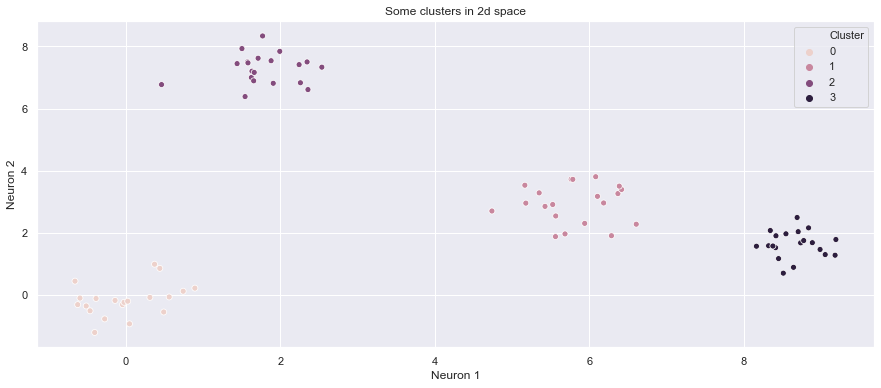

In [2]:
# make some data x as a numpy array of 2D points
n = 20 
nClusts = 4
clusterSize = (n, 2) # add 20 points from every cluster, 2 coords per point
np.random.seed(3)
x = np.random.normal(0, .5, clusterSize) # start w/ one cluster around 0 

for i in range(nClusts-1): 
    center = np.random.rand(2) * 10 # random center between 0 and 10 
    x = np.append(x, np.random.normal(center, .5, clusterSize), axis=0) #  

c = [c for s in [v * n for v in 'bgrcmk'[:nClusts]] for c in list(s)] 
labels = [l for s in [[v] * n for v in list(range(nClusts))] for l in list(s)] 
df = pd.DataFrame(np.array([x[:,0],x[:,1],labels]).T,columns = ["Neuron 1","Neuron 2","Cluster"])

plt.figure(figsize=(15, 6))
plt.title('Some clusters in 2d space')
sns.scatterplot(x = "Neuron 1", y = "Neuron 2",hue = "Cluster",data = df)
plt.show()

In [42]:
# Functions for AP!
def create_matrices(x,sharedPref = 'median'):
    S = squareform(pdist(x))  
    if sharedPref == 'median':
        np.fill_diagonal(S,np.median(S)) 
    elif sharedPref == 'min': 
        np.fill_diagonal(S,np.min(S[S > 0])) 
    elif type(sharedPref) == float: 
        np.fill_diagonal(S,sharedPref)  # real value
    R = np.zeros(S.shape) # initialize responsibility as similarity
    A = np.zeros(S.shape) # initialize availability as 
    return A, R, S

def update_r(lmda=0.9, slow=False):
    global R
    if slow:
        for i in range(x.shape[0]):
            for k in range(x.shape[0]):
                v = S[i, :] + A[i, :]
                v[k] = -np.inf
                v[i]= -np.inf
                R[i, k] = R[i, k] * lmda + (1 - lmda) * (S[i, k] - np.max(v))
    
    else:
        # For every column k, except for the column with the maximum value the max is the same.
        # So we can subtract the maximum for every row, and only need to do something different for k == argmax
        
        v = S + A
        rows = np.arange(x.shape[0])
        # We only compare the current point to all other points, so the diagonal can be filled with -infinity
        np.fill_diagonal(v, -np.inf)

        # max values
        idx_max = np.argmax(v, axis=1)
        first_max = v[rows, idx_max]

        # Second max values. For every column where k is the max value.
        v[rows, idx_max] = -np.inf
        second_max = v[rows, np.argmax(v, axis=1)]

        # Broadcast the maximum value per row over all the columns per row.
        max_matrix = np.zeros_like(R) + first_max[:, None]
        max_matrix[rows, idx_max] = second_max

        new_val = S - max_matrix

        R = R * lmda + (1 - lmda) * new_val

def update_a(lmda=0.9, slow=False):
    global A
    
    if slow:
        for i in range(x.shape[0]):
            for k in range(x.shape[0]):
                v = np.array(R[:, k])
                if i != k:
                    v[i] = -np.inf
                    v[k] = - np.inf
                    v[v < 0] = 0

                    A[i, k] = A[i, k] * lmda + (1 - lmda) * min(0, R[k, k] + v.sum())
                else:
                    v[k] = -np.inf
                    v[v < 0] = 0
                    A[k, k] = A[k, k] * lmda + (1 - lmda) * v.sum()
    else:
        k_k_idx = np.arange(x.shape[0])
        # set a(i, k)
        v = np.array(R)
        v[v < 0] = 0
        np.fill_diagonal(v, 0)
        v = v.sum(axis=0) # columnwise sum
        v = v + R[k_k_idx, k_k_idx]

        # broadcasting of columns 'r(k, k) + sum(max(0, r(i', k))) to rows.
        v = np.ones(A.shape) * v

        # For every column k, subtract the positive value of k. 
        # This value is included in the sum and shouldn't be
        v -= np.clip(R, 0, np.inf)
        v[v > 0] = 0
        
        # set(a(k, k))
        v_ = np.array(R)
        np.fill_diagonal(v_, 0)

        v_[v_ < 0] = 0

        v[k_k_idx, k_k_idx] = v_.sum(axis=0) # column wise sum
        A = A * lmda + (1 - lmda) * v

def plot_iteration(A, R):
    fig = plt.figure(figsize=(12, 6))
    sol = A + R
    
    labels = np.argmax(sol, axis=1)

    exemplars = np.unique(labels)
    colors = dict(zip(exemplars, cycle('bgrcmyk')))
    
    for i in range(len(labels)):
        X = x[i][0]
        Y = x[i][1]
        
        if i in exemplars:
            exemplar = i
            edge = 'k'
            ms = 10
        else:
            exemplar = labels[i]
            ms = 3
            edge = None
            plt.plot([X, x[exemplar][0]], [Y, x[exemplar][1]], c=colors[exemplar])
        plt.plot(X, Y, 'o', markersize=ms,  markeredgecolor=edge, c=colors[exemplar])
        

    plt.title('Number of exemplars: %s' % len(exemplars))
    return fig, labels, exemplars
    


In [43]:
# visualization
def plot_iteration(A,R):
    fig = plt.figure(figsize=(12, 6))
    sol = A + R
    # every data point i chooses the maximum index k
    labels = np.argmax(sol, axis=1)
    exemplars = np.unique(labels)
    colors = dict(zip(exemplars, cycle('bgrcmyk')))
    
    for i in range(len(labels)):
        X = x[i][0]
        Y = x[i][1]
        
        if i in exemplars:
            exemplar = i
            edge = 'k'
            ms = 10
        else:
            exemplar = labels[i]
            ms = 3
            edge = None
            plt.plot([X, x[exemplar][0]], [Y, x[exemplar][1]], c=colors[exemplar])
        plt.plot(X, Y, 'o', markersize=ms,  markeredgecolor=edge, c=colors[exemplar])
        

    plt.title('Number of exemplars: %s' % len(exemplars))
    return fig, labels, exemplars

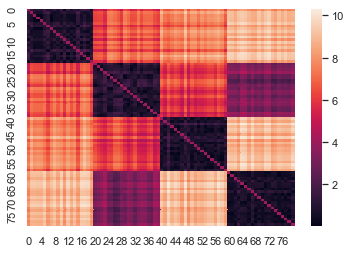

In [44]:
A,R,S = create_matrices(x,sharedPref = 4.);
sns.heatmap(S);


CPU times: user 1.14 s, sys: 18.6 ms, total: 1.15 s
Wall time: 1.23 s


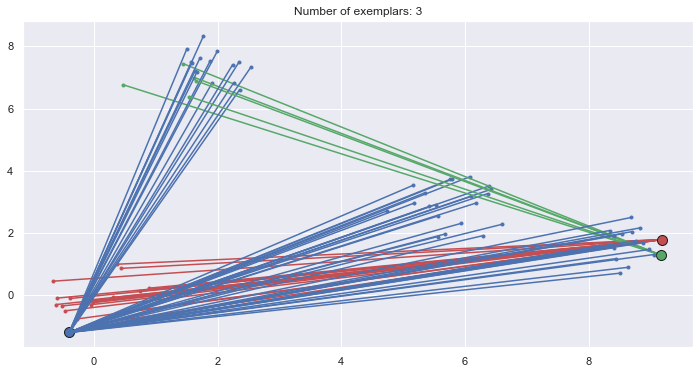

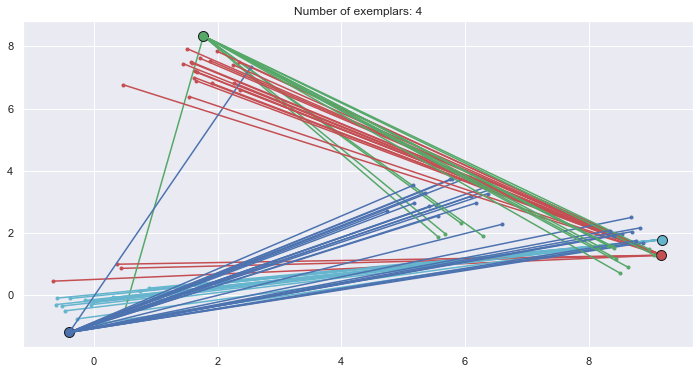

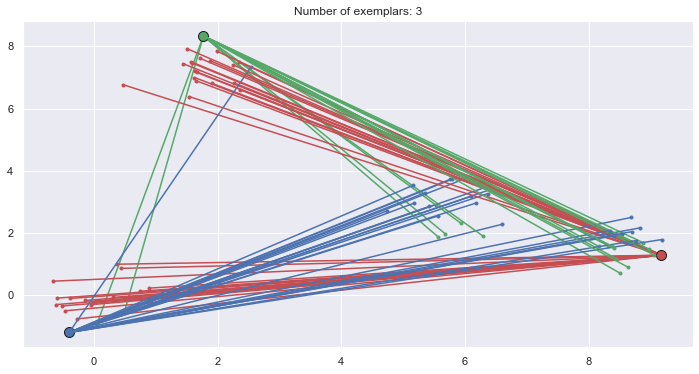

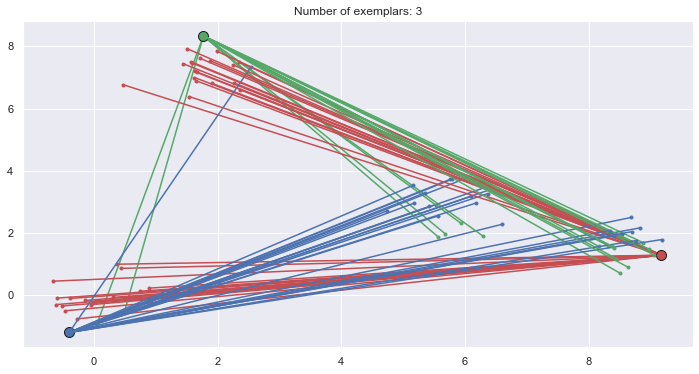

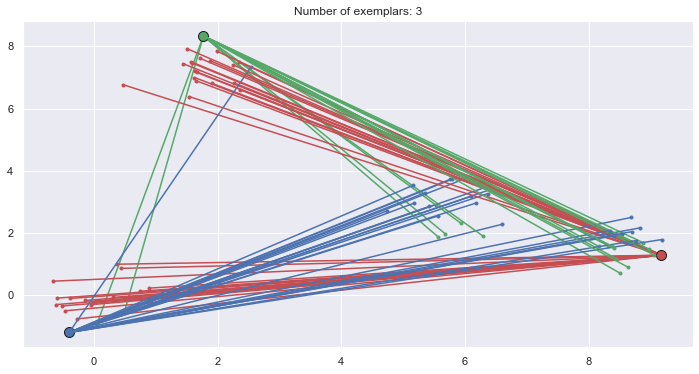

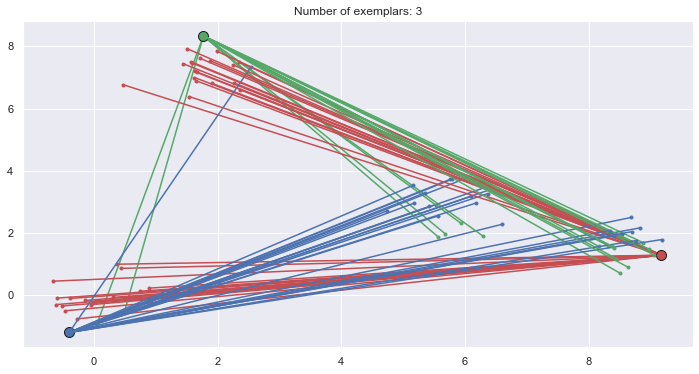

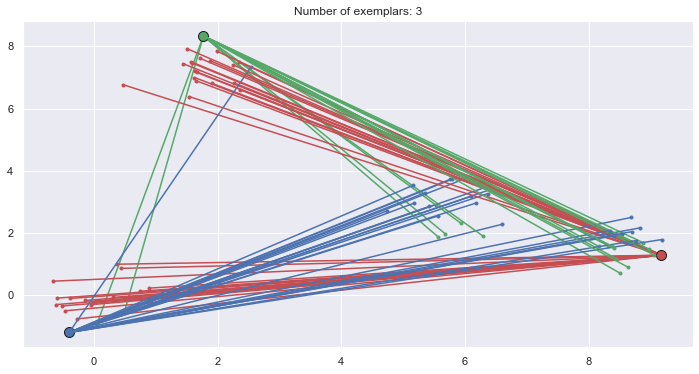

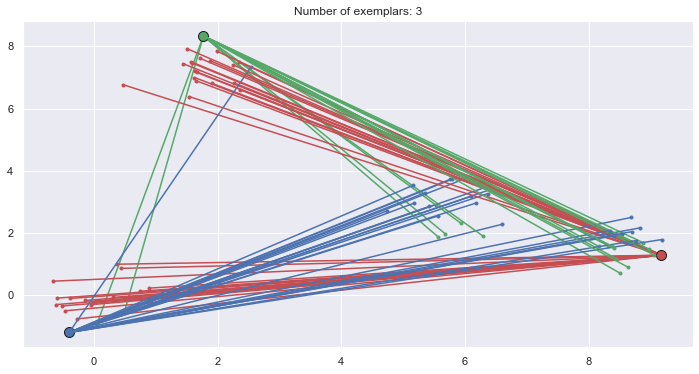

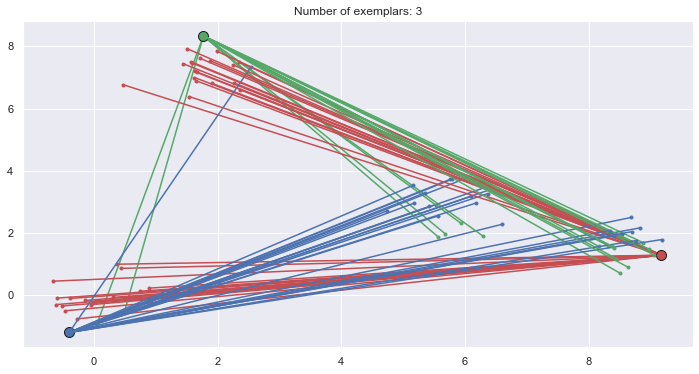

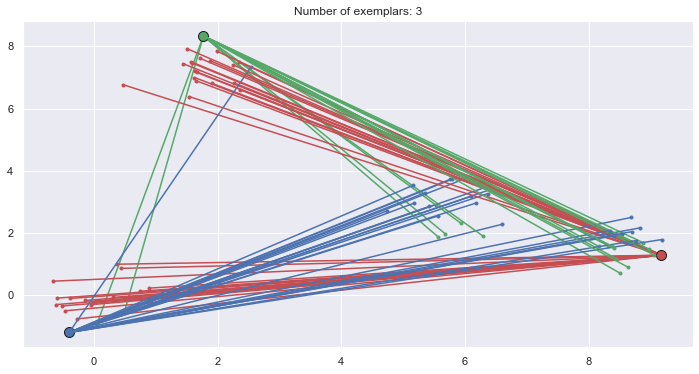

In [47]:
%%time
A, R, S = create_matrices(x)
preference = np.median(S)
# preference =  -1000

np.fill_diagonal(S, preference)
damping = 0.5

figures = []
for i in range(50):
    update_r(damping)
    update_a(damping, 0)
    
    if i % 5 == 0:
        fig, labels, exemplars = plot_iteration(A, R)
        figures.append(fig)
    

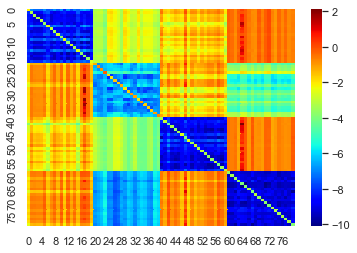

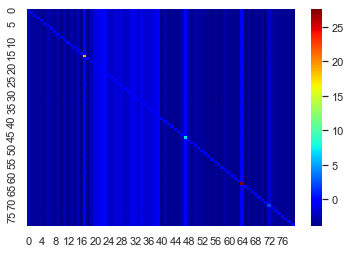

In [39]:
plt.figure()
sns.heatmap(R,cmap = 'jet') 
plt.figure() 
sns.heatmap(A,cmap = 'jet')

In [63]:
pd.DataFrame(np.array([x[:,0],x[:,1],labels]).T,columns = ["x","y","label"])

,x,y,label
0,1.788628,0.436510,0.0
1,0.096497,-1.863493,0.0
2,-0.277388,-0.354759,0.0
3,-0.082741,-0.627001,0.0
4,-0.043818,-0.477218,0.0
...,...,...,...
115,4.723679,7.926034,5.0
116,4.557786,9.799458,5.0
117,5.190538,8.891375,5.0
118,5.208892,9.511542,5.0
